# Sentiment Classification on Product Reviews
### Programming Language: python 3.6



### Load Libraries

In [1]:
#Importing the required packages for text-preprocessing
!pip install textblob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import re
import nltk
from nltk.corpus import reuters
nltk.download('wordnet')
from textblob import Word
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


# Importing the required packages to build and run the recurrent neural network

!pip install --ignore-installed --upgrade tensorflow-gpu
!pip install keras
import keras
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, LSTM, Embedding,MaxPooling1D, Flatten
from keras.layers.convolutional import Conv1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import spacy


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 345.2MB 57kB/s 
     |████████████████████████████████| 102kB 27.0MB/s 
     |████████████████████████████████| 51kB 20.2MB/s 
     |████████████████████████████████| 51kB 19.6MB/s 
     |████████████████████████████████| 3.2MB 25.7MB/s 
     |████████████████████████████████| 1.2MB 28.3MB/s 
     |████████████████████████████████| 17.3MB 27.4MB/s 
     |████████████████████████████████| 2.2MB 21.4MB/s 
     |████████████████████████████████| 368kB 42.8MB/s 
     |████████████████████████████████| 2.8MB 26.2MB/s 
     |████████████████████████████████| 92kB 29.1MB/s 
     |████████████████████████████████| 327kB 45.7MB/s 
     |████████████████████████████████| 583kB 41.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/ee/98/38/

Using TensorFlow backend.


In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib
#Checking if tensorflow is using GPU backend
print(tf.__version__)
print(keras.__version__)
print(device_lib.list_local_devices())

1.13.1
2.2.4
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16487169645136371717
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14143621885267284636
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2237339621873888475
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11323765556
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6934348996789906982
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [28]:
# Mount google drive to load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [9]:
#Reading the datasets provided
print('Loading Train Data....')
train_data = pd.read_csv("/content/drive/My Drive/train_data.csv")
print('Train Data successfully loaded.')
print('Loading Test Data....')
test_data = pd.read_csv("/content/drive/My Drive/test_data.csv")
print('Test data successfully loaded.')
print('Loading Train labels....')
train_label = pd.read_csv("/content/drive/My Drive/train_label.csv")
print('Train labels successfully loaded.')



Loading Train Data....
Train Data successfully loaded.
Loading Test Data....
Test data successfully loaded.
Loading Train labels....
Train labels successfully loaded.


In [10]:
#Vocabulary Distribution
train_words =  pd.Series(' '.join(train_data['text']).split())
train_words=pd.DataFrame(train_words, columns=['count'])
train_words_list = list(train_words['count'])

test_words = pd.Series(' '.join(test_data['text']).split())
test_words=pd.DataFrame(test_words, columns=['count'])
test_words_list = list(test_words['count'])

train_vocab = set(train_words_list)
test_vocab = set(test_words_list)

lexical_diversity = len(train_words)/len(train_vocab)
print('Before pre-processing...')
print("Vocabulary Size: ", len(train_vocab), "\nLexical Diversity: " ,lexical_diversity)

Before pre-processing...
Vocabulary Size:  1000874 
Lexical Diversity:  79.86894254421635


### EDA

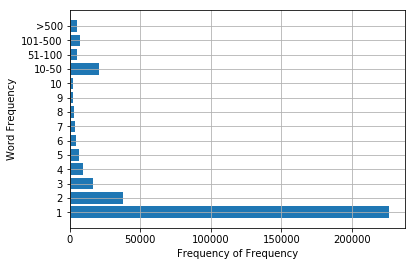

In [0]:
from nltk.probability import *
fd_1 = FreqDist(train_words_list)

#Refered from tutorial
ffd = FreqDist(fd_1.values())
from pylab import *
y = [0]*14
for k, v in ffd.items():
    if k<=10:
        y[k-1] = v
    elif k>10 and k<=50:
        y[10] = y[10] + v
    elif k>50 and k<=100:
        y[11] = y[11] + v
    elif k>100 and k<=500:
        y[12] = y[12] + v
    else:
        y[13] = y[13] + v
        
x = range(1, 15) # generate integer from 1 to 14
ytks =list(map(str, range(1, 11))) # covert a integer list to a string list
ytks.append('10-50')
ytks.append('51-100')
ytks.append('101-500')
ytks.append('>500')
barh(x,y, align='center')
yticks(x, ytks)
xlabel('Frequency of Frequency')
ylabel('Word Frequency')
grid(True)
    

The horizontal bar chart generated shows how many word types occur with certain frequency.

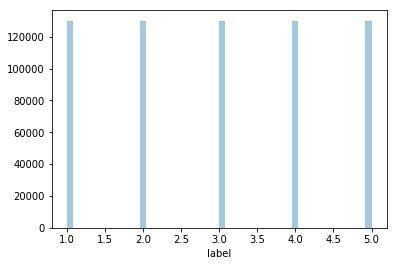

In [0]:
import seaborn as sns
sns.distplot(train_label['label'], kde = False,);

**Above figure displays the count of sentiment label, labels in train data are fairly distributed**

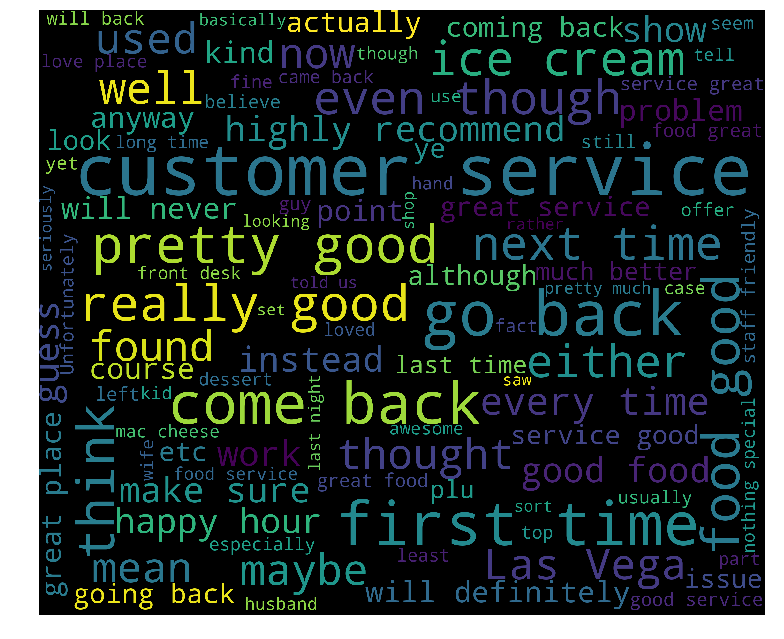

In [0]:
# install wordcloud library
# Code Inspiration
# https://www.geeksforgeeks.org/generating-word-cloud-python/

!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
#most_common = fd_1.most_common(25)

split_word = " ".join(train_words_list)

# Generate word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, 
                      background_color='black',
                      width=3000,
                      height=2500,
                      max_words = 100 # select top 100 words only.
                     ).generate(split_word)

plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Above are the top 100 words in the vocab, size of the each word indicates its frequency,

### Text Pre-processing

In [11]:
#To calculate total running time
import time
start = time.time()


#Function to do the preprocessing
def preProcessing(x):
    #Converting the entire text to lower
    y1 = x.lower()
    #Removing all the puntuations and special characters
    y2 = re.sub('[^\w\s]','',y1)
    # Removing the stopwords
    y3 = ' '.join(x for x in y2.split() if x not in stop)
    #Removing all words that have length less than 3
    y4 = ' '.join(re.findall('\w{3,}',y3))
    #Removing all numbers/digits
    y5 = re.sub('\d+','',y4)
    # fix spelling mistakes
    y6 = re.sub(r'(.)\1{3,}','\\1',y5)
    #lemmetization of all similar words
    y7 = ' '.join([Word(word).lemmatize() for word in y6.split()])
        
    return(y7) # Return pre-processed text
    


print('Pre-processing Train data...')
train_data['text'] = train_data['text'].apply(lambda x: preProcessing(x))
print('Train data processing complete.')

print('Pre-processing Test data...')
test_data['text'] = test_data['text'].apply(lambda x: preProcessing(x))
print('Test data processing complete.')


end = time.time()
time_taken = end - start
print('Time taken to pre-process: ',time_taken)

Pre-processing Train data...
Train data processing complete.
Pre-processing Test data...
Test data processing complete.
Time taken to pre-process:  533.3802785873413


In [12]:
#Vocabulary Distribution
train_words =  pd.Series(' '.join(train_data['text']).split())
train_words=pd.DataFrame(train_words, columns=['count'])
train_words_list = list(train_words['count'])

test_words = pd.Series(' '.join(test_data['text']).split())
test_words=pd.DataFrame(test_words, columns=['count'])
test_words_list = list(test_words['count'])

train_vocab = set(train_words_list)
test_vocab = set(test_words_list)

lexical_diversity = len(train_words)/len(train_vocab)

print('After pre-processing.')
print("Vocabulary Size: ", len(train_vocab), "\nLexical Diversity: " ,lexical_diversity)

After pre-processing.
Vocabulary Size:  349195 
Lexical Diversity:  112.3033691776801


### Corpus Statistics

In [0]:
train_data['totalWords']= train_data['text'].str.split().str.len()
print('The average number of tokens present in a review:',sum(train_data['totalWords'])/len(train_data['totalWords']))
print('The maximum number of tokens in a review:',max(train_data['totalWords']))
print('The minimum number of tokens in a review:', min(train_data['totalWords']))
print('SD of the size of the reviews:', train_data['totalWords'].std())

The average number of tokens present in a review: 60.33196153846154
The maximum number of tokens in a review: 555
The minimum number of tokens in a review: 0
SD of the size of the reviews: 53.898560663729995


### Model Generation

In [13]:
#Tokenizing the input data
tokenizer = Tokenizer(num_words= 8000, split=" ")
tokenizer.fit_on_texts(train_data['text'].values)

#Top 8000 words that needed to be passed into the embedding layer
tokenizer = Tokenizer(num_words= 8000, split=" ")
tokenizer.fit_on_texts(train_data['text'].values)

#Converting each review in the form of word embeddings 
X = tokenizer.texts_to_sequences(train_data['text'].values)
#Padding the data so each review has equal length, i.e 250
X = pad_sequences(X, maxlen=250)

#Converting each review in the form of word embeddings 
X_test = tokenizer.texts_to_sequences(test_data['text'].values)
#Padding the data so each review has equal length, i.e 250
X_test = pad_sequences(X_test, maxlen = 250)

print('Shape of Train Embedding: ', X.shape)
print('\nShape of Test Embedding: ', X_test.shape)



Shape of Train Embedding:  (650000, 250)

Shape of Test Embedding:  (50000, 250)


In [14]:
#Creating dummies of the train labels to get it to the standards required by the model
y = pd.get_dummies(train_label['label']).values
y.shape

(650000, 5)

In [15]:
#Checking the stucture of train labels
[print(train_label['label'][i], y[i]) for i in range(0,5)]

2 [0 1 0 0 0]
5 [0 0 0 0 1]
1 [1 0 0 0 0]
1 [1 0 0 0 0]
5 [0 0 0 0 1]


[None, None, None, None, None]

In [16]:
##Adding layers to the model

#The sequential layer to add the inputs
model = Sequential()
#Embedding layer which contains the vocab size, i.e top 8000 tokens from all the reviews as declared in the word embeddings
model.add(Embedding(8000, 300, input_length=X.shape[1]))
#Dropout of 0.5 to stop the overfitting that was taking place in test runs
model.add(Dropout(0.5))
#The first LSTM layer with return sequences as True and dropping a portion of the previous data
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
#Anaother LSTM layer with high dropout and low recurrent dropout
model.add(LSTM(256, dropout=0.4, recurrent_dropout=0.2))
#Dense layer which has the no. of nodes equal to no. of classes
model.add(Dense(5, activation='softmax'))

#Compiling the model with adam optimizer
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          2400000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 256)          570368    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 3,496,965
Trainable params: 3,496,965
Non-trainable params: 0
___________

In [0]:
#####################Takes around 1.

#Please change the epochs from 4-8 to get the optimum accuracy on the test dataset 
#You may change the batch size as well

batch_size = 400
epochs= 6  
#Validation set of 0.33 on each epoch
history = model.fit(X, y, epochs=epochs, validation_split=0.33, batch_size=batch_size)

#Keeping a track of train and validation loss, accuracy
print(history.history['loss'])
print(history.history ['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

In [0]:
predictions = model.predict(X_test)
predictions_new = np.argmax(predictions, axis=1)
error_df = pd.DataFrame()
error_df['label'] = predictions_new+1
error_df['test_id']=test_data['test_id']
error_df.to_csv('/content/drive/My Drive/Colab Notebooks/predict_label.csv', index=False)